# Цена машины с пробегом

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

##### [1. Подготовка данных](#Part_1)

##### 2. Обучение моделей
* [2.1 DecisionTreeClassifier](#Part_2)
* [2.2 Линейная регрессия](#Part_2.4)
* [2.3 Дерево регрессии](#Part_2.4)
* [2.4 Градиентый бустинг с OHE](#Part_2.4)
* [2.5 Градиентый бустинг без OHE](#Part_2.5)

##### [3. Анализ моделей](#Part_3)

<a id='Part_1'></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Посмотрим столбцы на наличее аномалий.

In [5]:
np.sort(df['RegistrationYear'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [6]:
np.sort(df['RegistrationMonth'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [7]:
np.sort(df['Power'].unique())

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

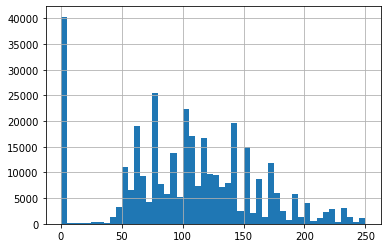

In [8]:
df['Power'].hist(bins=50, range=(0,250))

In [9]:
np.sort(df['Price'].unique())

array([    0,     1,     2, ..., 19998, 19999, 20000])

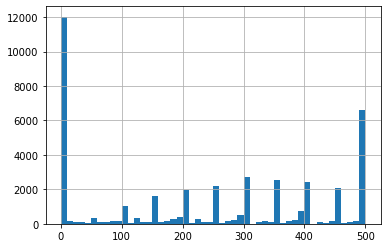

In [10]:
df['Price'].hist(bins=50, range=(0,500))

#### Промежуточный вывод
Видим, что имеется очень большой разброс даты регистрации авто, ограничим максимальный год до 2016, поскольку это дата сбора информации. Цену авто ограничим снизу до 100. Так же избавимся в колонках года, мощности и цены от выбросов.

In [11]:
df = df.loc[df['RegistrationYear'] <= 2016]

In [12]:
df = df.loc[df['Price'] >= 100]

In [13]:
cols = ['RegistrationYear','Power','Price'] # one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [14]:
df['NumberOfPictures'].unique()

array([0])

* Добавим новый признак - возраст автомобиля, определим его как разницу между датой сбора информации и указаной датой регистрации авто.

* Заполним пропуски значением unknown
* Удалим столбцы ['DateCrawled','RegistrationYear','RegistrationMonth','DateCreated','LastSeen','NumberOfPictures']
* Проведем OHE кодирование данных

In [15]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], yearfirst=True)

In [16]:
df['Age'] = df['DateCrawled'].dt.year.unique() - df['RegistrationYear']

In [17]:
# заполняем пропуски категорией unknow
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')


In [18]:
df = df.drop(['DateCrawled','RegistrationYear','RegistrationMonth','DateCreated','LastSeen','NumberOfPictures'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301012 entries, 0 to 354368
Data columns (total 11 columns):
Price          301012 non-null int64
VehicleType    301012 non-null object
Gearbox        301012 non-null object
Power          301012 non-null int64
Model          301012 non-null object
Kilometer      301012 non-null int64
FuelType       301012 non-null object
Brand          301012 non-null object
NotRepaired    301012 non-null object
PostalCode     301012 non-null int64
Age            301012 non-null int64
dtypes: int64(5), object(6)
memory usage: 27.6+ MB


In [20]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [21]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301012 entries, 0 to 354368
Columns: 309 entries, Price to NotRepaired_yes
dtypes: int64(5), uint8(304)
memory usage: 101.0 MB


<a id='Part_2'></a>
# 2. Обучение моделей
Выделим целевой признак и трейн признаки, разобьем датасет на тренировычный и тестовый в отношении 80/20.
Проведем замер времени обучения и предсказания для трех классических моделей регрессии, а также для градиентного бустинга.
## 2.1 Линейная регрессия

In [22]:
target = df_ohe['Price']
features = df_ohe.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.8, random_state=42)

In [23]:
features_train.shape, features_test.shape

((240809, 308), (60203, 308))

In [24]:
%%time
start = time.time()  
# fit
model = LinearRegression().fit(features_train, target_train)
LinearRegression_time_fit = time.time() - start

CPU times: user 20.5 s, sys: 7.59 s, total: 28.1 s
Wall time: 28.2 s


In [25]:
%%time
start = time.time()
# predict
predict_test = model.predict(features_test)
LinearRegression_rmse = mean_squared_error(target_test, predict_test) ** 0.5
print('The rmse of prediction is:', LinearRegression_rmse)
LinearRegression_time_predict = time.time() - start

The rmse of prediction is: 1971.6235072830593
CPU times: user 113 ms, sys: 154 ms, total: 266 ms
Wall time: 288 ms


<a id='Part_2.2'></a>
## 2.2 Дерево регрессии

In [26]:
model = DecisionTreeRegressor(random_state=42)
parametrs = {'max_depth': range(1, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_absolute_error')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 14}

In [27]:
%%time
start = time.time() 
# fit
model = DecisionTreeRegressor(max_depth=14, random_state=42).fit(features_train, target_train)
DecisionTreeRegressor_time_fit = time.time() - start

CPU times: user 7.64 s, sys: 204 ms, total: 7.84 s
Wall time: 7.93 s


In [28]:
%%time
start = time.time() 
# predict
predict_test = model.predict(features_test)
DecisionTreeRegressor_rmse = mean_squared_error(target_test, predict_test) ** 0.5
print('The rmse of prediction is:', DecisionTreeRegressor_rmse)
DecisionTreeRegressor_time_predict = time.time() - start

The rmse of prediction is: 1500.3598759982178
CPU times: user 91.1 ms, sys: 44.8 ms, total: 136 ms
Wall time: 146 ms


<a id='Part_2.3'></a>
## 2.3 Случайный лес регрессии

In [30]:
%%time
start = time.time() 
# fit
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=42).fit(features_train, target_train)
RandomForestRegressor_time_fit = time.time() - start

CPU times: user 3min 12s, sys: 342 ms, total: 3min 13s
Wall time: 3min 18s


In [31]:
%%time
start = time.time() 
# predict
predict_test = model.predict(features_test)
RandomForestRegressor_rmse = mean_squared_error(target_test, predict_test) ** 0.5
print('The rmse of prediction is:', RandomForestRegressor_rmse)
RandomForestRegressor_time_predict = time.time() - start

The rmse of prediction is: 1387.9391571208894
CPU times: user 580 ms, sys: 55.8 ms, total: 636 ms
Wall time: 642 ms


<a id='Part_2.4'></a>
## 2.4 Градиентый бустинг с OHE

In [32]:
# model
gbm = lgb.LGBMRegressor(random_state=42)

In [33]:
%%time
start = time.time() 
# model
gbm = lgb.LGBMRegressor(learning_rate=0.1,
                        max_depth = 7,
                        n_estimators=200,
                        num_leaves=200,
                        random_state=42
                       )
# fit
gbm.fit(features_train, target_train,
        eval_set=[(features_train, target_train),(features_test,target_test)],
        eval_metric='rmse',
        early_stopping_rounds=5,
        verbose = 20)
LGBMRegressor_ohe_time_fit = time.time() - start

Training until validation scores don't improve for 5 rounds
[20]	training's rmse: 1576.52	training's l2: 2.48541e+06	valid_1's rmse: 1581.27	valid_1's l2: 2.50042e+06
[40]	training's rmse: 1392.46	training's l2: 1.93895e+06	valid_1's rmse: 1407.61	valid_1's l2: 1.98136e+06
[60]	training's rmse: 1345.92	training's l2: 1.81151e+06	valid_1's rmse: 1365.17	valid_1's l2: 1.86368e+06
[80]	training's rmse: 1324.9	training's l2: 1.75536e+06	valid_1's rmse: 1346.3	valid_1's l2: 1.81252e+06
[100]	training's rmse: 1311.08	training's l2: 1.71894e+06	valid_1's rmse: 1335.35	valid_1's l2: 1.78317e+06
[120]	training's rmse: 1298.94	training's l2: 1.68723e+06	valid_1's rmse: 1325.26	valid_1's l2: 1.75631e+06
[140]	training's rmse: 1289.5	training's l2: 1.66282e+06	valid_1's rmse: 1318.08	valid_1's l2: 1.73734e+06
[160]	training's rmse: 1278.55	training's l2: 1.6347e+06	valid_1's rmse: 1309.92	valid_1's l2: 1.7159e+06
[180]	training's rmse: 1272.18	training's l2: 1.61845e+06	valid_1's rmse: 1305.43	val

In [34]:
%%time
start = time.time() 
# predict
predict_test = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
# eval
LGBMRegressor_ohe_rmse = mean_squared_error(target_test, predict_test) ** 0.5
print('The rmse of prediction is:', LGBMRegressor_ohe_rmse)
LGBMRegressor_ohe_time_predict = time.time() - start

The rmse of prediction is: 1300.8280528495993
CPU times: user 1.9 s, sys: 87.7 ms, total: 1.99 s
Wall time: 2 s


<a id='Part_2.5'></a>
## 2.5 Градиентый бустинг без OHE

In [35]:
target = df['Price']
features = df.drop('Price', axis=1)

In [36]:
#set categorical features
features['PostalCode'] = features['PostalCode'].astype('category')
for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        features[c] = features[c].astype('category')

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.8, random_state=42)

In [38]:
features_train.shape, features_test.shape

((240809, 10), (60203, 10))

In [39]:
# model
gbm = lgb.LGBMRegressor(random_state=42)

In [40]:
%%time
start = time.time() 
# model
gbm = lgb.LGBMRegressor(learning_rate=0.1,
                        max_depth = 7,
                        n_estimators=200,
                        num_leaves=100,
                        random_state=42
                       )
# fit
gbm.fit(features_train, target_train,
        eval_set=[(features_train, target_train),(features_test,target_test)],
        eval_metric='rmse',
        early_stopping_rounds=5,
        verbose = 20)

LGBMRegressor_time_fit = time.time() - start

Training until validation scores don't improve for 5 rounds
[20]	training's rmse: 1445.95	training's l2: 2.09078e+06	valid_1's rmse: 1460.05	valid_1's l2: 2.13173e+06
[40]	training's rmse: 1269.81	training's l2: 1.61242e+06	valid_1's rmse: 1314.11	valid_1's l2: 1.72688e+06
[60]	training's rmse: 1226.63	training's l2: 1.50462e+06	valid_1's rmse: 1294.67	valid_1's l2: 1.67616e+06
[80]	training's rmse: 1206.56	training's l2: 1.45578e+06	valid_1's rmse: 1288.29	valid_1's l2: 1.6597e+06
[100]	training's rmse: 1189.2	training's l2: 1.41419e+06	valid_1's rmse: 1282.6	valid_1's l2: 1.64505e+06
[120]	training's rmse: 1178.65	training's l2: 1.38922e+06	valid_1's rmse: 1279.94	valid_1's l2: 1.63826e+06
[140]	training's rmse: 1167.88	training's l2: 1.36394e+06	valid_1's rmse: 1277.43	valid_1's l2: 1.63183e+06
[160]	training's rmse: 1157.24	training's l2: 1.3392e+06	valid_1's rmse: 1275.79	valid_1's l2: 1.62763e+06
[180]	training's rmse: 1147.25	training's l2: 1.31619e+06	valid_1's rmse: 1273.72	va

In [41]:
%%time
start = time.time() 
# predict
predict_test = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
# eval
LGBMRegressor_rmse = mean_squared_error(target_test, predict_test) ** 0.5
print('The rmse of prediction is:', LGBMRegressor_rmse)
LGBMRegressor_time_predict = time.time() - start

The rmse of prediction is: 1271.638297604815
CPU times: user 3 s, sys: 7.53 ms, total: 3.01 s
Wall time: 3.04 s


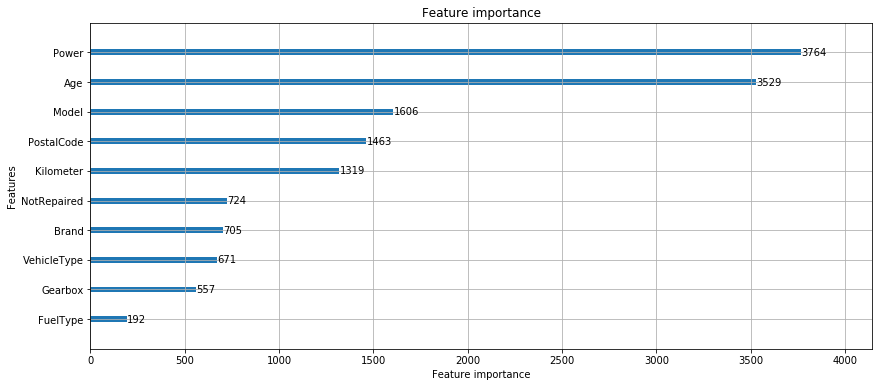

In [42]:
lgb.plot_importance(gbm, max_num_features=10, figsize=(14,6))

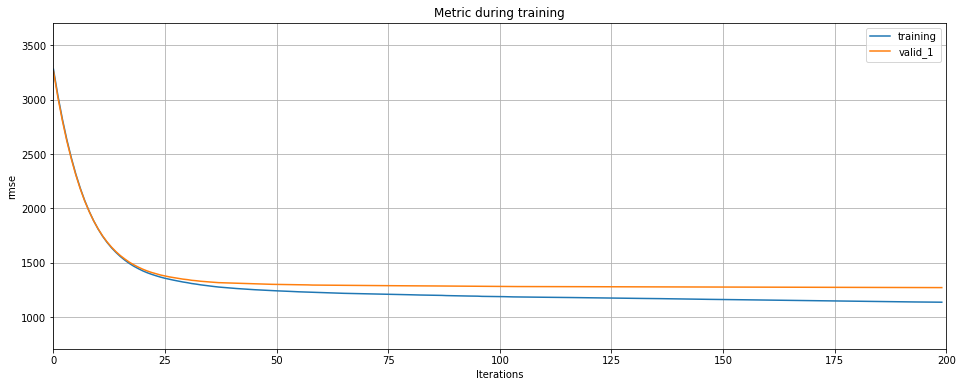

In [43]:
lgb.plot_metric(gbm, 'rmse', figsize=(16,6))

<a id='Part_3'></a>
# 3. Анализ моделей
Соберем в единую таблицу полученные измерения и оценки

In [44]:
df2 = pd.DataFrame(np.array([['LinearRegression',LinearRegression_time_fit, LinearRegression_time_predict, LinearRegression_rmse],
                             ['DecisionTreeRegressor',DecisionTreeRegressor_time_fit, DecisionTreeRegressor_time_predict, DecisionTreeRegressor_rmse], 
                             ['RandomForestRegressor',RandomForestRegressor_time_fit, RandomForestRegressor_time_predict, RandomForestRegressor_rmse],
                             ['LGBMRegressor_ohe',LGBMRegressor_ohe_time_fit, LGBMRegressor_ohe_time_predict, LGBMRegressor_ohe_rmse],
                             ['LGBMRegressor',LGBMRegressor_time_fit, LGBMRegressor_time_predict, LGBMRegressor_rmse]]),
                   columns=['Model','Time fit', 'Time predict', 'RMSE'])

In [45]:
for col in ['Time fit', 'Time predict', 'RMSE']:
    df2[col] = df2[col].astype('float')

In [46]:
df2.round(2)

,Model,Time fit,Time predict,RMSE
0,LinearRegression,28.20,0.29,1971.62
1,DecisionTreeRegressor,7.93,0.15,1500.36
2,RandomForestRegressor,198.62,0.64,1387.94
3,LGBMRegressor_ohe,24.64,2.00,1300.83
4,LGBMRegressor,240.60,3.04,1271.64


## Вывод
* Как видно из сводной таблицы модель градиентного бустинга оказалась самой точной среди всех остальных моделей, но за это приходиться расплачиваться большим временем обучения и предсказания. 
* Линейная регрессия оказалась самой неточной моделью. 
* Самой быстрой моделью как по времени предсказания, так и по времени обучения стала модель дерева решений. 
* Модель случайного леса регрессии оказалась самой компромисной как по результату, так и по скорости работы(в зависимости от загрузки на сервер).